### BRIa Project - Resting state EEG Analysis 

Author: Juraj Dedic, xdedic07

In [94]:
# from scipy.io import loadmat
import mne
from db import engine, Base, load_recoding
from sqlalchemy.orm import sessionmaker
from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
Session = sessionmaker(bind=engine)
session = Session()

### Download from DB

In [69]:
ch_names, data_EC = load_recoding(session, 6, tqdm_notebook)

data_EC = np.array(data_EC)

Loading channel data from DB:   0%|          | 0/64 [00:00<?, ?channel/s]

[14128800. 14129800. 14125500. ... 14407900. 14408900. 14404500.]
[14128800. 14129800. 14125500. ... 14407900. 14408900. 14404500.]
Creating RawArray with float64 data, n_channels=64, n_times=38401
    Range : 0 ... 38400 =      0.000 ...    18.750 secs
Ready.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_40464\452583215.py:22: RuntimeWarning: The unit for channel(s) Afz has changed from V to NA.
  raw.set_channel_types({'Afz': 'misc'})


<RawArray | 64 x 38401 (18.8 s), ~18.8 MB, data loaded>

### Create MNE Raw object

In [75]:
# print the first 10 values of FP1
print(data_EC[0])
eeg_EC = data_EC * 1e-6 # convert to volts
print(eeg_EC[0])

# create info object
info = mne.create_info(
    ch_names=ch_names,
    ch_types=['eeg']*64, #+ ['eog']*3 + ['misc']*1,
    sfreq=256)

# create raw object
raw = mne.io.RawArray(eeg_EC, info)


montage = mne.channels.make_standard_montage('biosemi64')
# Afz will not be part of ICA
raw.set_channel_types({'Afz': 'misc'})
raw.set_montage(montage)

[14128800. 14129800. 14125500. ... 14407900. 14408900. 14404500.]
[14.1288 14.1298 14.1255 ... 14.4079 14.4089 14.4045]
Creating RawArray with float64 data, n_channels=64, n_times=38401
    Range : 0 ... 38400 =      0.000 ...   150.000 secs
Ready.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_40464\2605242062.py:18: RuntimeWarning: The unit for channel(s) Afz has changed from V to NA.
  raw.set_channel_types({'Afz': 'misc'})


<RawArray | 64 x 38401 (150.0 s), ~18.8 MB, data loaded>

### Initial plot

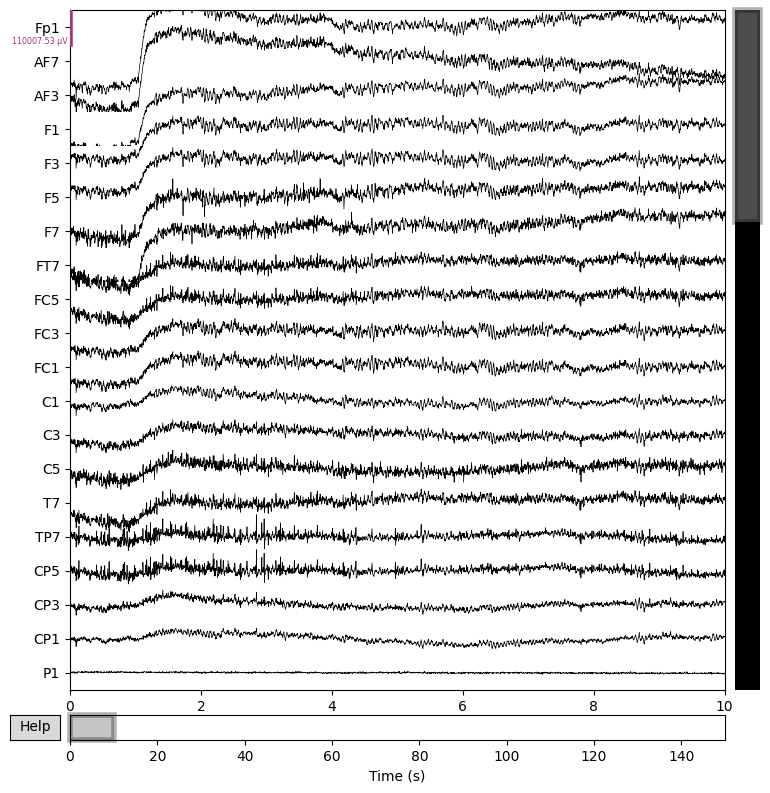

In [119]:
raw.plot(n_channels=20, title="Before", scalings='auto');

### Setting reference

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


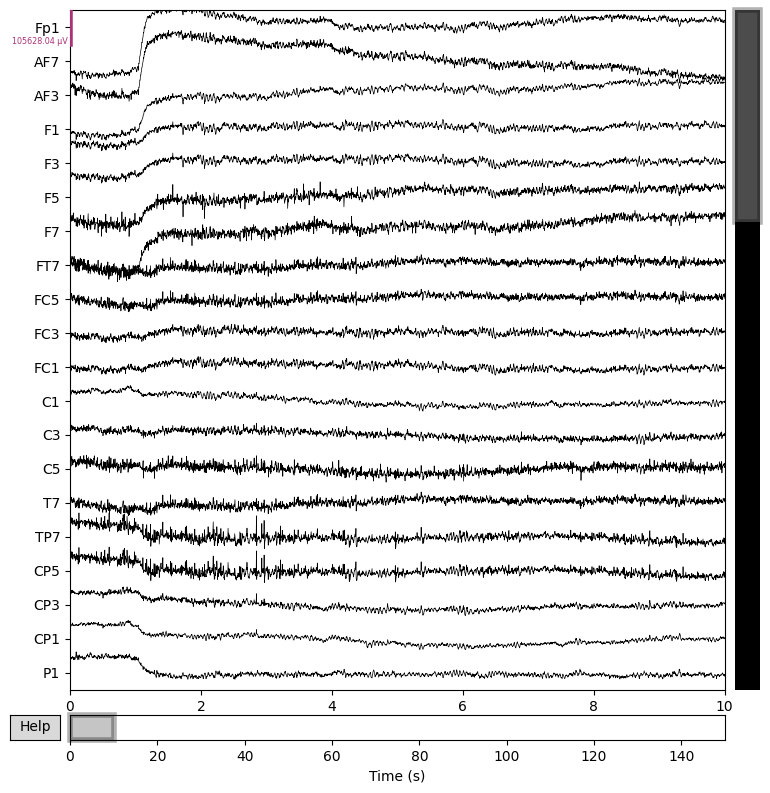

In [150]:
# raw_new_ref = raw.copy()
# raw_new_ref.set_eeg_reference(ref_channels=["Cz"])
# raw_new_ref.plot(n_channels=20, title="Before", scalings='auto');

raw_new_ref = raw.copy()
raw_new_ref.set_eeg_reference(ref_channels="average")
raw_new_ref.plot(n_channels=20, title="Before", scalings='auto');

### Downsampling

In [ ]:
# raw_downsampled = raw.copy().resample(sfreq=200)
# raw_downsampled.plot(n_channels=20, start=10, duration=60, title="After", scalings=dict(eeg=0.05));

### Remove low frequency drifts

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.1s finished


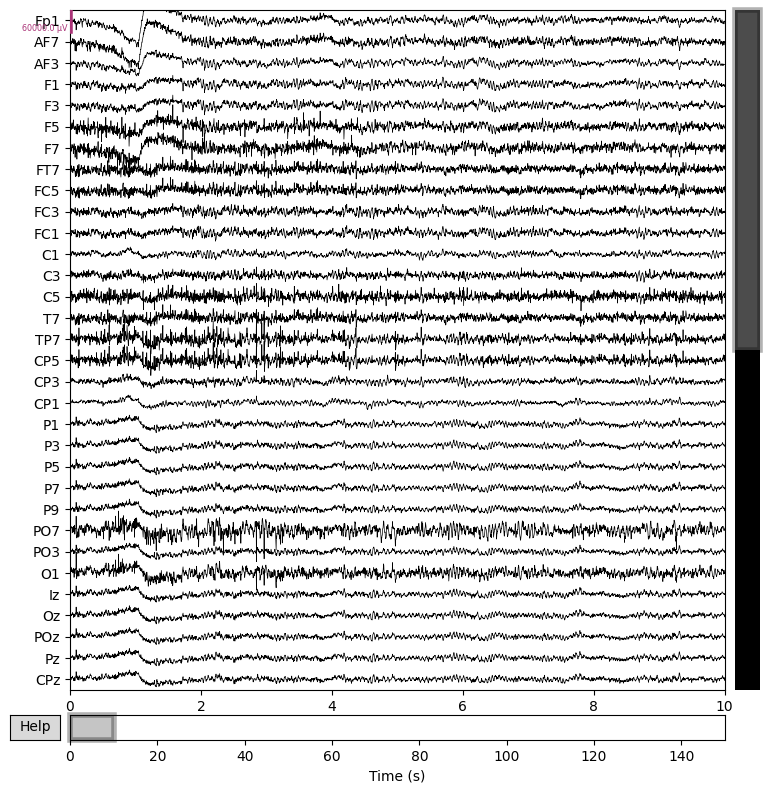

In [154]:
# remove slow drifts
raw_straightened = raw_new_ref.copy()
raw_straightened = raw_straightened.filter(l_freq=1.0, h_freq=None)
raw_straightened.plot(n_channels=32, title="After", scalings=dict(eeg=0.03));

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



Fitting ICA to data using 63 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.0s finished


Selecting by non-zero PCA components: 62 components
Fitting ICA took 23.8s.


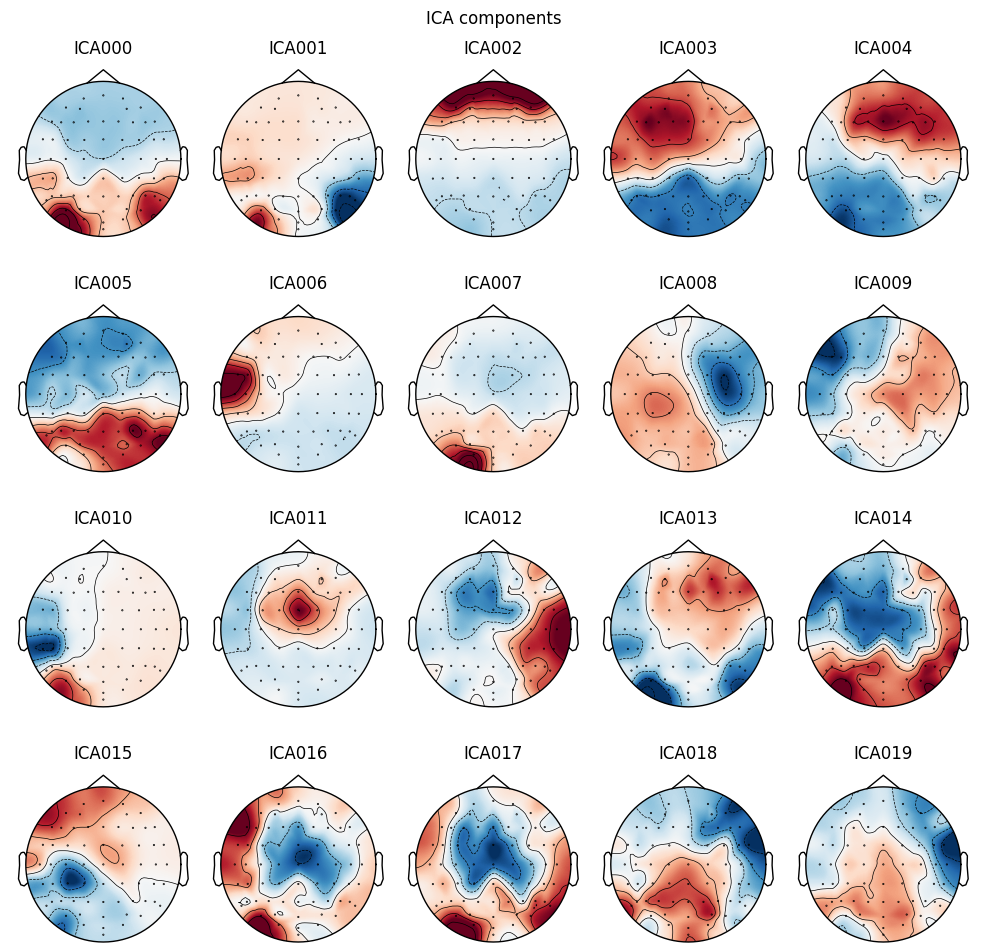

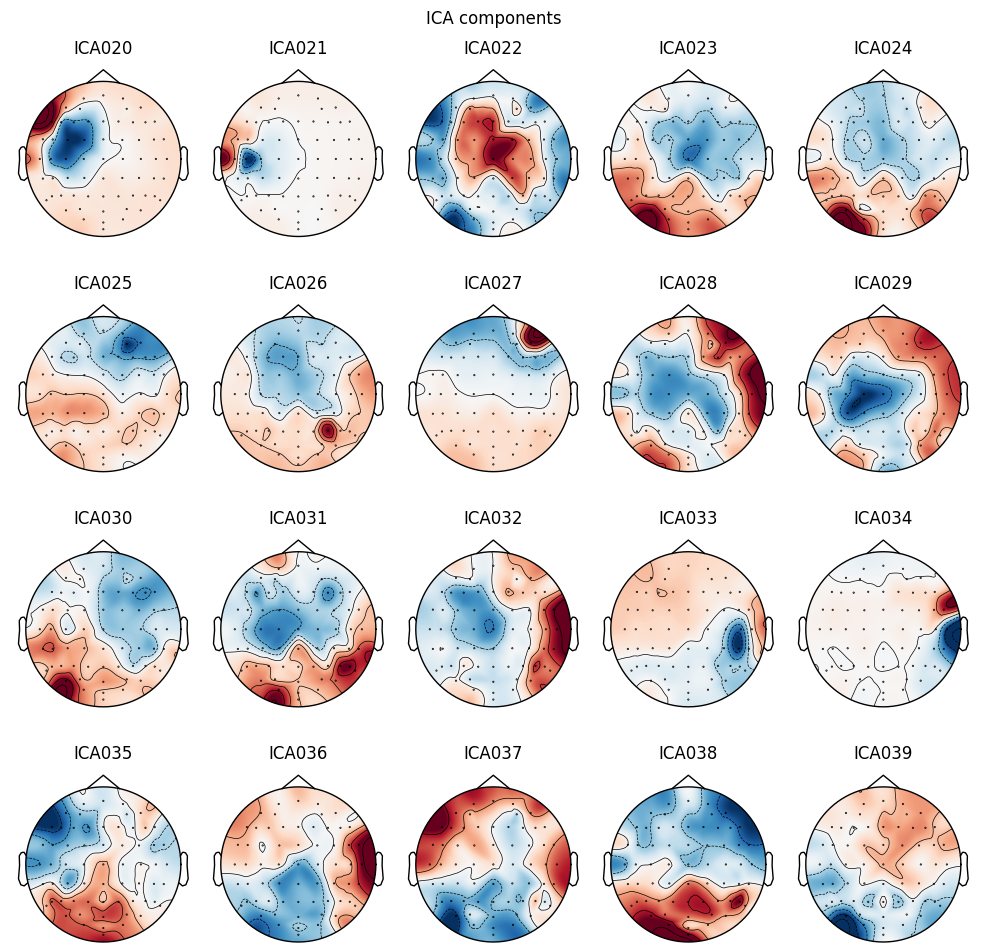

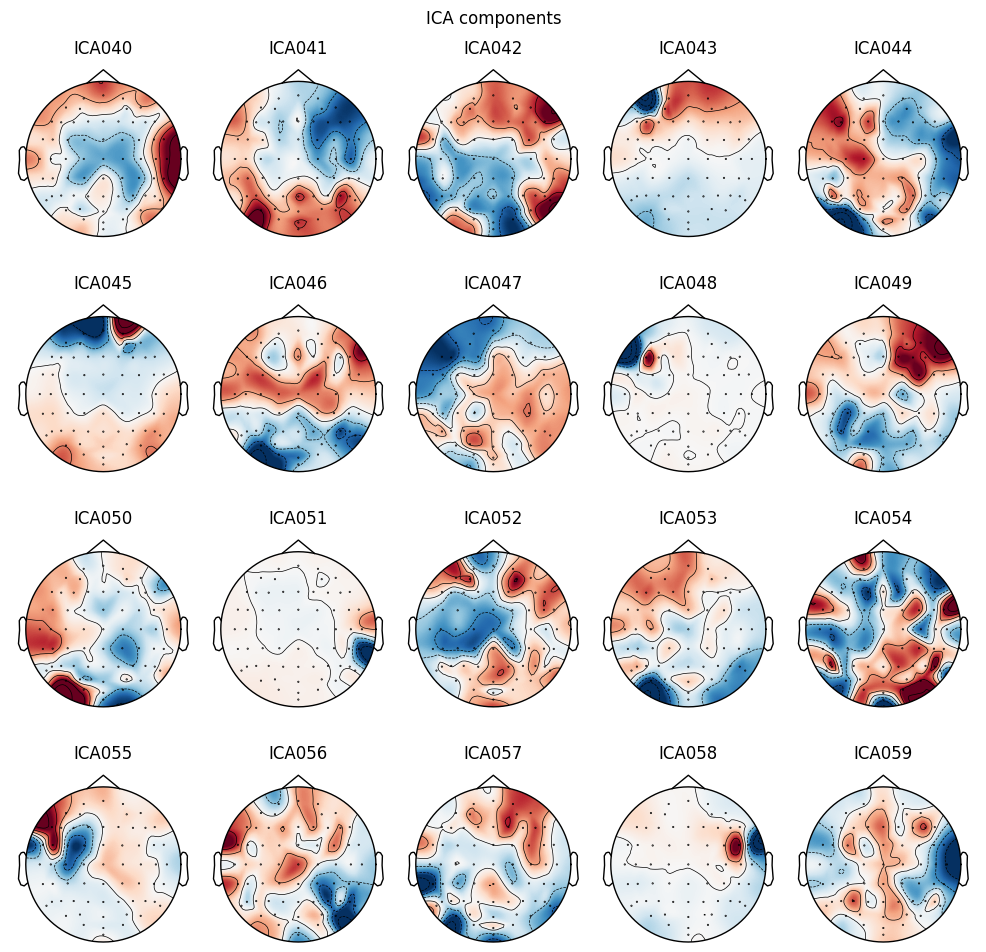

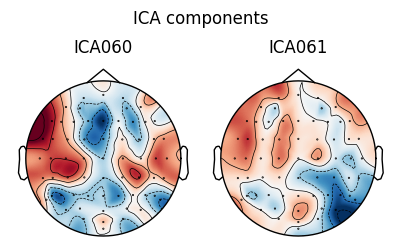

In [122]:
raw_tmp = raw_straightened.copy()
raw_tmp.filter(l_freq=1, h_freq=None)
ica = mne.preprocessing.ICA(method="picard") 
fit_params={"extended": True}
random_state=1
ica.fit(raw_tmp)

ica.plot_components(inst=raw_tmp);

### Variance explained by ICA components

In [123]:
explained_var_ratio = ica.get_explained_variance_ratio(raw_straightened)
for channel_type, ratio in explained_var_ratio.items():
    print(
        f"Fraction of {channel_type} variance explained by all components: " f"{ratio}"
)

Fraction of eeg variance explained by all components: 1.0


Fraction of variance in EEG signal explained by component 1: 10%


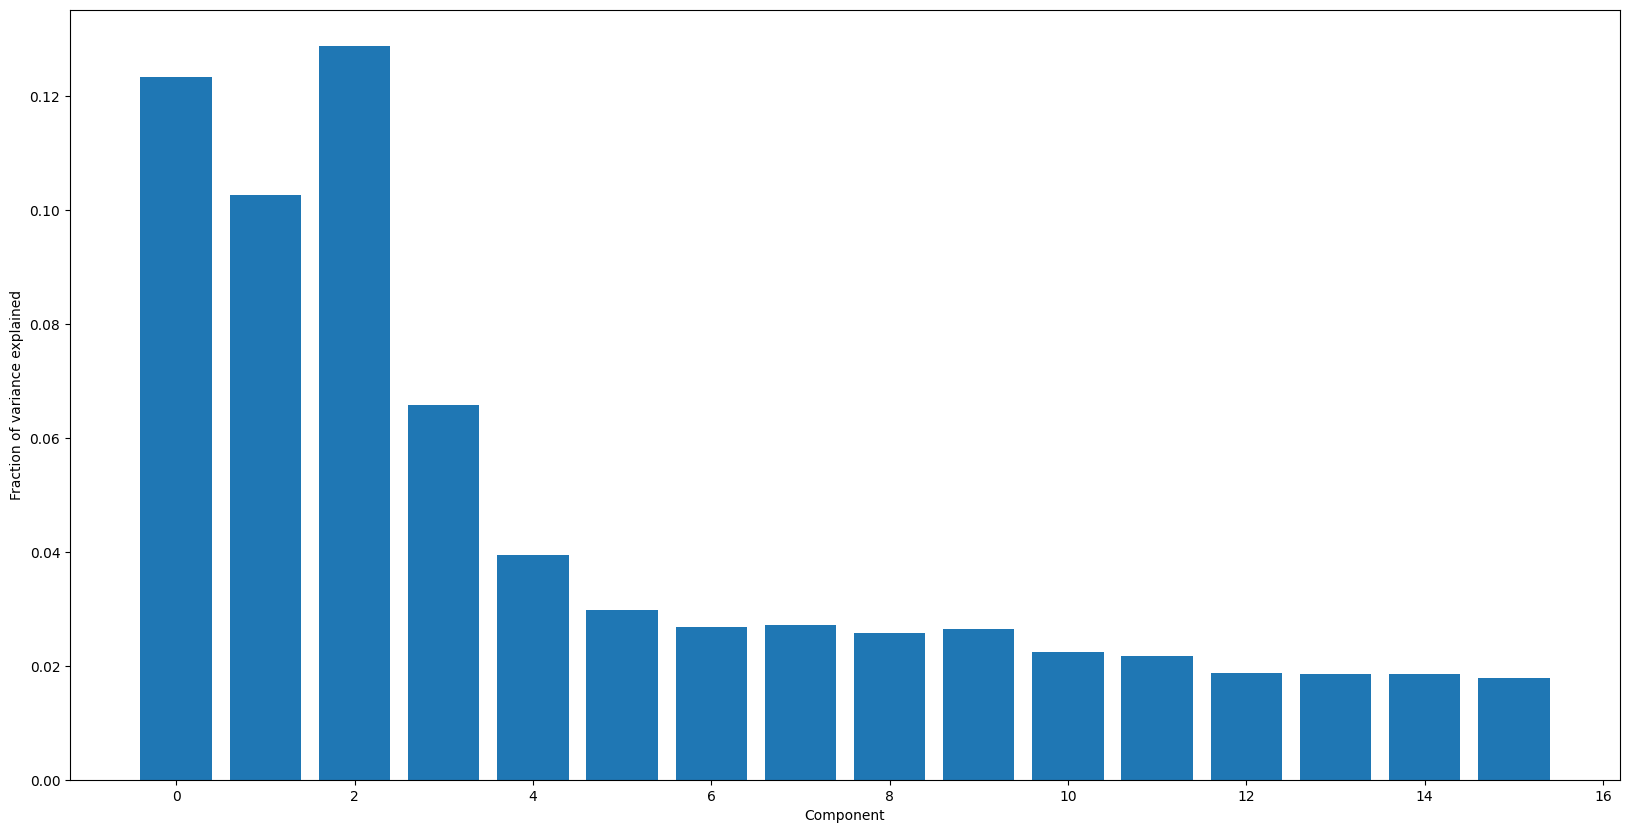

In [134]:
def variance_explained_by(i, print_percentage=True):
    explained_var_ratio = ica.get_explained_variance_ratio(
        raw_straightened, components=[i], ch_type="eeg"
    )
    # This time, print as percentage.
    if print_percentage:
        ratio_percent = round(100 * explained_var_ratio["eeg"])
        print(
            f"Fraction of variance in EEG signal explained by component "+str(i)+": "
            f"{ratio_percent}%"
        )

    return explained_var_ratio["eeg"]

variance_explained_by(1, True)


n = 16
# plot the variance explained by each component
variance_explained = []
for i in range(0, n):
    variance_explained.append(variance_explained_by(i, False))

# plot as bar chart with each component on the x-axis labelleds
plt.figure(figsize=(20, 10))
plt.bar(range(0, n), variance_explained)
plt.xlabel("Component")
plt.ylabel("Fraction of variance explained")
plt.show();


### Plot ICA time series

Creating RawArray with float64 data, n_channels=62, n_times=38401
    Range : 0 ... 38400 =      0.000 ...   150.000 secs
Ready.


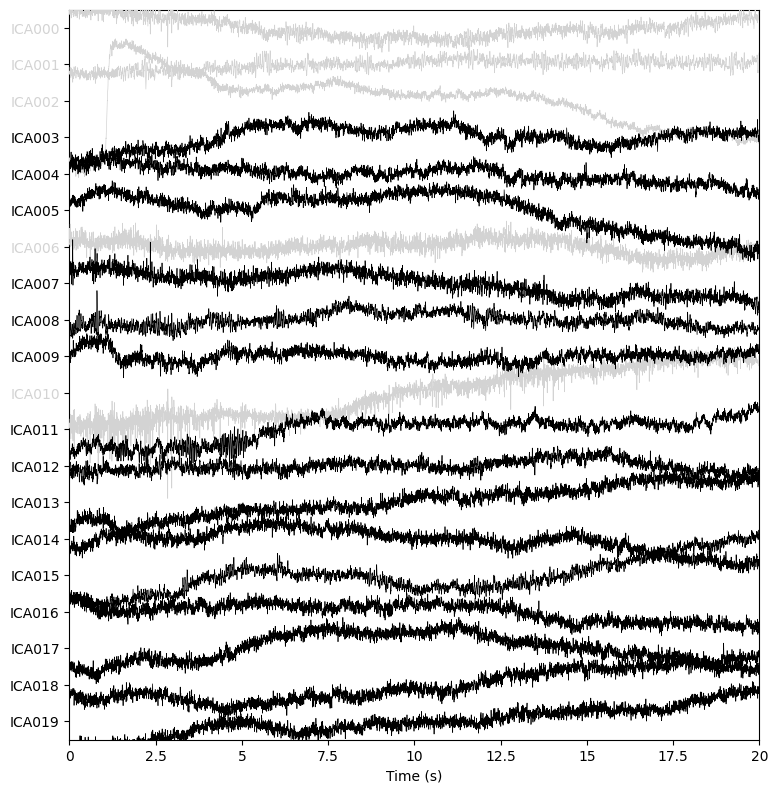

In [172]:
raw.load_data()
ica.plot_sources(raw, show_scrollbars=False, title="ICA components");

## Remove EEG artifacts using ICA

Applying ICA to Raw instance
    Transforming to ICA space (62 components)
    Zeroing out 5 ICA components
    Projecting back using 63 PCA components


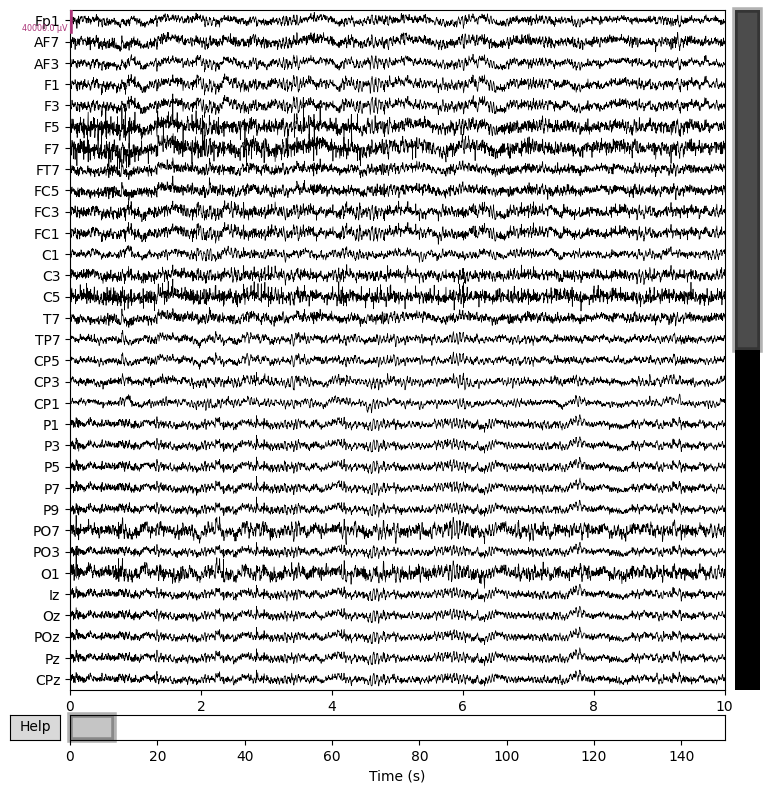

In [173]:
ica.exclude = [0,1,2,6,10]
raw_corrected = raw_straightened.copy()

ica.apply(raw_corrected)
raw_corrected.plot(n_channels=32, title="After", scalings=dict(eeg=0.02));

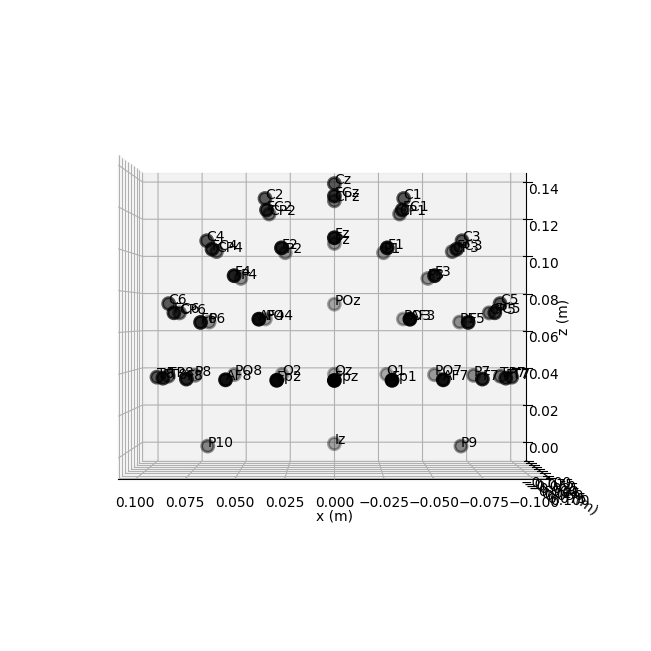

Feature Extraction for Classification:
Spectral Features: Band power ratios, dominant
frequency, spectral entropy.
Statistical Features: Mean, variance, skewness, kurtosis
of EEG signals.
Connectivity Features: Coherence, phase-locking, 

5. Connectivity Features:
Connectivity features reveal the interactions and
synchronization between different brain regions:
Coherence: Measures the linear relationship between
two EEG signals at different frequency bands, indicating
the degree of synchronization.
Phase-Locking Value (PLV): Quantifies the phase
consistency between different EEG channels, reflecting
functional connectivity.

In [175]:
epochs = mne.make_fixed_length_epochs(raw=raw_corrected, duration=0.5, overlap=0.25)
times = epochs.times
ch_names = epochs.ch_names

Not setting metadata
599 matching events found
No baseline correction applied
0 projection items activated


In [178]:
import os.path as op

import mne
from mne_connectivity import spectral_connectivity_epochs
from mne.datasets import sample
from mne_connectivity.viz import plot_sensors_connectivity

# Pick MEG gradiometers
picks = mne.pick_types(
    raw.info, meg=False, eeg=True, stim=False, eog=False
)

# Compute connectivity for band containing the evoked response.
# We exclude the baseline period:
fmin, fmax = 4.0, 9.0
sfreq = raw.info["sfreq"]  # the sampling frequency
tmin = 0.0  # exclude the baseline period
epochs.load_data().pick_types(eeg=True)
con = spectral_connectivity_epochs(
    epochs,
    method="pli",
    mode="multitaper",
    sfreq=sfreq,
    fmin=fmin,
    fmax=fmax,
    faverage=True,
    tmin=tmin,
    mt_adaptive=False,
    n_jobs=1,
)

# Now, visualize the connectivity in 3D:
plot_sensors_connectivity(epochs.info, con.get_data(output="dense")[:, :, 0])

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Replacing existing metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 1953 connections
    using t=0.000s..0.496s for estimation (128 points)
    frequencies: 4.0Hz..8.0Hz (3 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: PLI
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    co

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_40464\2786706064.py:19: RuntimeWarning: fmin=4.000 Hz corresponds to 2.000 < 5 cycles based on the epoch length 0.500 sec, need at least 1.250 sec epochs or fmin=10.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 21
    computing cross-spectral density for epoch 22
    computing cross-spectral density for epoch 23
    computing cross-spectral density for epoch 24
    computing cross-spectral density for epoch 25
    computing cross-spectral density for epoch 26
    computing cross-spectral density for epoch 27
    computing cross-spectral density for epoch 28
    computing cross-spectral density for epoch 29
    computing cross-spectral density for epoch 30
    computing cross-spectral density for epoch 31
    computing cross-spectral density for epoch 32
    computing cross-spectral density for epoch 33
    computing cross-spectral density for epoch 34
    computing cross-spectral density for epoch 35
    computing cross-spectral density for epoch 36
    computing cross-spectral density for epoch 37
    computing cross-spectral density for epoch 38
    computing cross-spectral density for epoch 39
    computing cross-spectral density for epoch 40


Exception ignored in: <function BasePlotter.__del__ at 0x00000223540191C0>
Traceback (most recent call last):
  File "c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyvista\plotting\plotter.py", line 6117, in __del__
    if self._initialized:
       ^^^^^^^^^^^^^^^^^
AttributeError: 'Plotter' object has no attribute '_initialized'


TypeError: Plotter.__init__() got an unexpected keyword argument 'multi_samples'